In [1]:
# import capytaine as cpy
import autograd.numpy as np
import matplotlib.pyplot as plt
import xarray as xr
# from math import comb

import wecopttool as wot
import os
import Pioneer_Inverted_Pendulum as pip

## set colorblind-friendly colormap for plots
plt.style.use('tableau-colorblind10')

wot.set_loglevel('INFO', capytaine=False)
data_path = os.path.join('pioneer_data')

In [2]:
wavefreq = 0.325
f1_reg = wavefreq
nfreq_reg = 5
amplitude = 0.15

waves_regular = wot.waves.regular_wave(f1_reg, nfreq_reg, wavefreq, amplitude)

In [3]:
NPIP = pip.NonlinearInvertedPendulumPTO(f1 = f1_reg,
                                        nfreq = nfreq_reg,
                                        ndof = 1,
                                        control_type = 'P')

In [4]:
LinPIP = pip.LinearizedInvertedPendulumPTO(f1 = f1_reg,
                                        nfreq = nfreq_reg,
                                        ndof = 1,
                                        control_type = 'P')

In [6]:
wec_nl = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq_reg, 
                                            f_add = NPIP.f_add,
                                            constraints = NPIP.constraints)
wec_lin = pip.PioneerBuoy.from_empirical_data(f1_reg, nfreq_reg, 
                                            f_add = LinPIP.f_add,
                                            constraints = LinPIP.constraints)  

In [7]:
res_lin = wec_lin.solve(
    waves_regular,
    obj_fun = LinPIP.average_electrical_power,
    nstate_opt = LinPIP.nstate_opt,
    optim_options={'maxiter': 500},
    # x_wec_0=x_wec_0, # initialize with result from linear spring case
    # x_opt_0=x_opt_0, # initialize with result from linear spring case
    scale_x_wec=1e1,
    scale_x_opt=np.concatenate((np.array([1e-1])*np.ones(LinPIP.nstate_pto), 1e-1 * np.ones(LinPIP.nstate_pen))),
    scale_obj=1e-2,
)

C:\Users\dtgaebe\WecOptTool\wecopttool\core.py:756: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for realization, wave in waves.groupby('realization'):
INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.25e+00, 5.21e-01, 7.18e-01]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.25e+00, 8.56e-01, 2.35e-02]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.25e+00, 1.01e+00, 9.83e-03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.25e+00, 1.02e+00, 9.76e-03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.25e+00, 1.02e+00, 9.75e-03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.25e+00, 1.05e+00, 9.71e-03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.005499846270165824
            Iterations: 32
            Function evaluations: 33
            Gradient evaluations: 32


In [8]:
x_wec_0, x_opt_0 = wec_lin.decompose_state(res_lin[0].x)


In [9]:
res_nl = wec_nl.solve(
    waves_regular,
    obj_fun = NPIP.average_electrical_power,
    nstate_opt = NPIP.nstate_opt,
    optim_options={'maxiter': 500},
    x_wec_0=x_wec_0, # initialize with result from linearized case
    x_opt_0=x_opt_0, # initialize with result from linearized case
    scale_x_wec=1e1,
    scale_x_opt=np.concatenate((np.array([1e-1])*np.ones(NPIP.nstate_pto), 1e-1 * np.ones(NPIP.nstate_pen))),
    scale_obj=1e-2,)

INFO:wecopttool.core:Solving pseudo-spectral control problem for realization number 0.
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.25e+00, 2.18e+01, -5.40e-03]
INFO:wecopttool.core:Scaled [max(x_wec), max(x_opt), obj_fun(x)]: [1.25e+00, 2.18e+01, -5.40e-03]
INFO:wecopttool.core:Optimization terminated successfully    (Exit mode 0)


Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.0054023323043013724
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2


In [11]:
nsubsteps = 4
wec_fdom, wec_tdom = wec_nl.post_process(wec_nl, res_nl, waves_regular, nsubsteps=nsubsteps)


In [17]:
wec_pos = wec_tdom[0]['pos'].squeeze()
t = wec_tdom[0].time.values


In [15]:
x_wec, x_opt = wot.decompose_state(res_nl[0].x, 1, nfreq_reg)
x_pen = x_opt[NPIP.nstate_pto:]
pen_pos = np.dot(wec_nl.time_mat_nsubsteps(nsubsteps), x_pen)

In [20]:
rel_pos = NPIP.rel_position(wec_nl, x_wec, x_opt, waves_regular, nsubsteps)

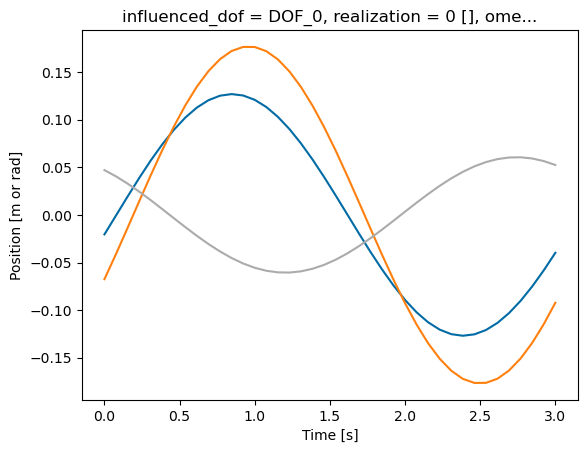

In [21]:
wec_pos.plot()
plt.plot(t, pen_pos)
plt.plot(t, rel_pos)